In [120]:
# every 100 data in train every 1 tuple in test

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
import copy


In [122]:
df = pd.read_csv(r'D:\PROGRAMMING\BE proj24\dataset\angles.csv')
df.head()

,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
0,0,0,16.926802,7.667874,18.982162,112.747505,112.62553,112.099300,101.05565
1,0,1,14.199318,8.954973,18.966124,109.707190,109.76263,110.645454,102.00027
2,0,2,18.065800,10.315741,17.527954,114.562100,112.08965,113.340350,104.09502
3,0,3,23.270214,17.336140,17.195545,117.674810,115.43172,114.634530,107.38297
4,0,4,22.831680,13.822096,17.355429,117.536720,117.96766,112.306390,98.39078


In [123]:
squats_df=df[(df['vid_id']>=385)& (df['vid_id']<=447)]
squats_df.head(11817)

,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72105,385,0,53.402206,73.528010,46.317870,149.35954,153.83890,118.31155,88.452630
72106,385,1,45.957460,81.406560,35.316982,118.72570,145.04758,108.92687,110.066660
72107,385,2,44.079243,79.323600,37.196740,103.62296,137.77670,103.73133,104.628716
72108,385,3,34.982906,78.514984,41.724506,86.89696,123.90274,93.21554,105.458960
72109,385,4,30.291750,78.184020,39.902603,87.05850,124.05390,87.08308,101.913830
...,...,...,...,...,...,...,...,...,...
83917,447,296,107.305360,90.115130,51.515130,134.34811,147.88246,136.57085,123.315970
83918,447,297,100.225420,94.343120,53.821750,146.84540,163.03261,140.31600,140.187360
83919,447,298,100.277790,89.232956,49.927440,137.95894,152.91435,136.71500,128.460190
83920,447,299,99.322820,87.257810,49.641770,148.99538,167.36041,138.74146,134.618380


In [124]:
scaler = MinMaxScaler()
squats_df.iloc[:, 2:] = scaler.fit_transform(squats_df.iloc[:, 2:])
squats_df.head()


C:\Users\siddh\AppData\Local\Temp\ipykernel_18504\3393851743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  squats_df.iloc[:, 2:] = scaler.fit_transform(squats_df.iloc[:, 2:])


,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72105,385,0,0.295393,0.411265,0.273035,0.829341,0.849218,0.658835,0.485592
72106,385,1,0.253775,0.455628,0.204535,0.654619,0.798166,0.606105,0.608375
72107,385,2,0.243276,0.443899,0.216240,0.568480,0.755944,0.576912,0.577484
72108,385,3,0.192425,0.439346,0.244433,0.473082,0.675377,0.517826,0.582200
72109,385,4,0.166201,0.437482,0.233089,0.474003,0.676255,0.483369,0.562061


In [125]:
A=squats_df.iloc[:,2:]
A

,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
72105,0.295393,0.411265,0.273035,0.829341,0.849218,0.658835,0.485592
72106,0.253775,0.455628,0.204535,0.654619,0.798166,0.606105,0.608375
72107,0.243276,0.443899,0.216240,0.568480,0.755944,0.576912,0.577484
72108,0.192425,0.439346,0.244433,0.473082,0.675377,0.517826,0.582200
72109,0.166201,0.437482,0.233089,0.474003,0.676255,0.483369,0.562061
...,...,...,...,...,...,...,...
83917,0.596722,0.504665,0.305397,0.743723,0.814629,0.761431,0.683641
83918,0.557143,0.528472,0.319760,0.815002,0.902607,0.782474,0.779482
83919,0.557436,0.499697,0.295511,0.764317,0.843849,0.762240,0.712863
83920,0.552098,0.488575,0.293732,0.827264,0.927738,0.773627,0.747846


In [126]:
squats_df = squats_df.sample(frac=1)
squats_df


,vid_id,frame_order,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_knee_mid_hip_left_knee,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder
80202,428,119,0.676737,0.627090,0.190337,0.340340,0.350437,0.862640,0.801606
74569,400,115,0.455350,0.466165,0.218595,0.794247,0.826551,0.814012,0.866049
83583,446,42,0.200090,0.358432,0.342013,0.596558,0.745617,0.663330,0.820116
83210,444,106,0.160095,0.141993,0.489085,0.614336,0.840352,0.723219,0.529900
82266,439,66,0.078267,0.230773,0.308612,0.772395,0.648126,0.656923,0.776245
...,...,...,...,...,...,...,...,...,...
81299,433,261,0.490824,0.479273,0.533088,0.366294,0.335417,0.859372,0.829273
74525,400,71,0.518605,0.597628,0.206473,0.299118,0.262396,0.853382,0.927486
73496,394,18,0.418646,0.296715,0.459487,0.787783,0.847157,0.640975,0.787760
72415,387,0,0.555667,0.269271,0.461996,0.431758,0.477565,0.935371,0.610814


In [127]:
class ExerciseDataset(Dataset):
    def __init__(self, data):
        # self.data = data
        # self.r_data = data[df.iloc[:,2:]].values
        self.data = data
        # Define the columns for X and y
        self.columns = [
            'right_elbow_right_shoulder_right_hip', 
            'left_elbow_left_shoulder_left_hip', 
            'right_knee_mid_hip_left_knee', 
            'right_hip_right_knee_right_ankle', 
            'left_hip_left_knee_left_ankle', 
            'right_wrist_right_elbow_right_shoulder', 
            'left_wrist_left_elbow_left_shoulder'
        ]
        # Extract only these columns from the DataFrame
        self.r_data = data[self.columns].values
    def __len__(self):
        # Since y is the next frame, we have one less sample in y
        return len(self.data) - 1

    def __getitem__(self, idx):
        # X is the current frame, y is the next frame in the sequence
        X = torch.tensor(self.r_data[idx], dtype=torch.float32)
        y = torch.tensor(self.r_data[idx + 1], dtype=torch.float32)  # Next frame as target
        return X, y



In [128]:
total_rows = squats_df.shape[0]
# Define an 80-20 split
train_size = int(0.8 * total_rows)
train_videos = squats_df[:train_size]
test_videos = squats_df[train_size:]



# Check the size of the splits
len(train_videos), len(test_videos)


(9453, 2364)

In [129]:
# Pass the train and test DataFrames into the custom Dataset
train_dataset = ExerciseDataset(train_videos)
test_dataset = ExerciseDataset(test_videos)

# Create DataLoaders from the datasets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [130]:
next(iter(train_dataloader))

[tensor([[2.5045e-01, 7.8934e-01, 6.4958e-01, 5.6899e-01, 1.2407e-01, 8.1102e-01,
          7.9977e-01],
         [3.8893e-01, 3.8736e-01, 1.5743e-01, 7.4721e-01, 6.9043e-01, 5.3732e-01,
          6.1179e-01],
         [5.5257e-01, 6.0856e-01, 2.1055e-01, 2.1028e-01, 2.0502e-01, 7.8351e-01,
          4.7829e-01],
         [9.3338e-01, 9.3022e-01, 1.1532e-01, 2.1002e-02, 9.4276e-04, 8.7497e-01,
          8.5284e-01],
         [6.2395e-01, 5.4249e-01, 3.4969e-01, 2.3065e-01, 1.8927e-01, 7.1099e-01,
          6.6770e-01],
         [3.6605e-01, 4.2159e-01, 2.3330e-01, 7.7169e-01, 8.1818e-01, 6.9244e-01,
          7.0588e-01],
         [7.1338e-01, 7.0401e-01, 2.4205e-01, 2.5237e-01, 1.6932e-01, 9.1285e-01,
          9.0034e-01],
         [3.1650e-01, 2.2969e-01, 1.0655e-01, 3.6878e-01, 3.4427e-01, 9.2617e-01,
          6.9570e-01],
         [8.2938e-02, 1.0297e-01, 3.5127e-01, 9.4497e-01, 8.9024e-01, 9.0780e-01,
          8.8526e-01],
         [2.8094e-01, 1.6005e-01, 2.8944e-01, 6.5465e-0

In [131]:
train_videos.shape

(9453, 9)

In [132]:
test_videos.shape

(2364, 9)

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [134]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [135]:
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [136]:
loss_fn = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [137]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [138]:
size = len(train_dataloader.dataset)
size

9452

In [139]:
for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        X=X.cpu().numpy()
        print(scaler.inverse_transform(X))
        break

[[115.48389   110.99036    21.206285   11.394423   12.196259  139.75015
  133.0788   ]
 [ 67.9643     57.114098   57.736824  173.12418   176.30449   116.88315
  119.86222  ]
 [ 74.86922    74.11184    32.236618   36.740807   43.2853     90.48226
   90.1611   ]
 [137.63379   144.28413    41.426598  155.79434   157.94627   130.2912
  152.44295  ]
 [111.55586   100.682915   58.928204  139.24129   154.61026   151.20921
  137.18388  ]
 [ 23.73252    73.01223    49.104347  138.1348    152.57986   113.80622
  147.37555  ]
 [ 69.07885    53.670097   60.99627   123.763374  163.49863   139.98477
  138.62851  ]
 [ 41.6922     70.0039     83.81562   151.73425    92.631386   86.523224
  101.562645 ]
 [141.50407   148.13698    41.76649   153.3016    155.70087   122.89365
  142.1607   ]
 [ 58.814907   37.344776   29.42818   137.90782   123.73415    92.1203
   61.371212 ]
 [ 48.43224    34.45993    91.09521    57.55928    51.232162   59.65965
  147.50754  ]
 [ 30.480137   61.763927  104.998024  128.10

In [140]:
X.shape

(64, 7)

In [141]:
def demo():
    for i in range(5):
        print(i)
        
demo()

0
1
2
3
4


In [142]:
for i in range(5):
    print(i)

0
1
2
3
4


In [143]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [144]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)



Epoch 1
-------------------------------
loss: 0.394359  [   64/ 9452]
loss: 0.291962  [ 6464/ 9452]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.259719 

Epoch 2
-------------------------------
loss: 0.261915  [   64/ 9452]
loss: 0.219669  [ 6464/ 9452]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.176117 

Epoch 3
-------------------------------
loss: 0.168284  [   64/ 9452]
loss: 0.139287  [ 6464/ 9452]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.119644 

Epoch 4
-------------------------------
loss: 0.119629  [   64/ 9452]
loss: 0.089103  [ 6464/ 9452]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.084498 

Epoch 5
-------------------------------
loss: 0.075979  [   64/ 9452]
loss: 0.069611  [ 6464/ 9452]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.064848 

Epoch 6
-------------------------------
loss: 0.063414  [   64/ 9452]
loss: 0.064266  [ 6464/ 9452]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.055007 

Epoch 7
-------------------------------
loss: 0.059176  [   64/ 9452]
loss: 0.052179  [ 6464/ 

In [145]:
# a function where i put my data , and it should predict next movement

In [146]:
def predict_next_movement(model, input_data):
    """
    Predict the next movement based on the input data.

    Parameters:
    - model: The trained neural network model.
    - input_data: A numpy array or torch tensor of shape (7,) representing the feature input.

    Returns:
    - predicted_output: A numpy array containing the predicted next movement values.
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Ensure the input data is a tensor and is on the correct device
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Predict the next movement
        predicted_output = model(input_tensor)

        # Convert the prediction to CPU and then to numpy array for easier handling
        predicted_output = predicted_output.cpu().numpy().flatten()

    return predicted_output

# Example usage:
# Assuming you're providing an initial input of shape (7,)
# For instance:
# input_data = np.array([value1, value2, value3, value4, value5, value6, value7])
# predicted_movement = predict_next_movement(model, input_data)
# print(predicted_movement)


In [147]:
# Example input data, replace with actual feature values
input_data = np.array([76.71837,70.530464,129.75558,165.34836,155.74284,144.40475,162.36722])  # Example values

# Call the prediction function
predicted_movement = predict_next_movement(model, input_data)

# Print the output
print("Predicted Next Movement:", predicted_movement)


Predicted Next Movement: [40.172543 62.518036 46.243584 84.65571  67.15253  84.29271  72.412254]


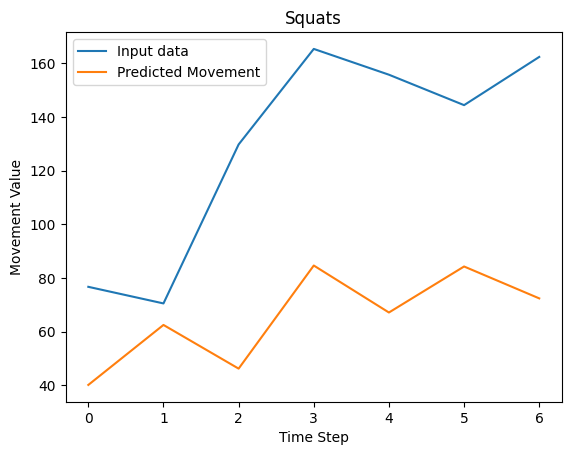

In [148]:
import matplotlib.pyplot as plt  
import numpy as np  
predicted_movement =predicted_movement
input_data = input_data
plt.plot(input_data, label='Input data')  
plt.plot(predicted_movement, label='Predicted Movement')  
plt.legend()  
plt.xlabel('Time Step')  
plt.ylabel('Movement Value')  
plt.title('Squats')  
plt.show()